- Scaling helps

In [ ]:
from sklearn import datasets, linear_model
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

In [ ]:
raw = diabetes_X[:, None, 2]

max_raw = max(raw)
min_raw = min(raw)
scaled = (2*raw - max_raw - min_raw)/(max_raw - min_raw)

In [ ]:
def train_raw():
    linear_model.LinearRegression().fit(raw, diabetes_y)

def train_scaled():
    linear_model.LinearRegression().fit(scaled, diabetes_y)

import timeit
raw_time = timeit.timeit(train_raw, number=1000)
scaled_time = timeit.timeit(train_scaled, number=1000)
print('Raw: {:.4f}s, Scaled: {:.4f}s, Improvement: {:2f}%'
      .format(raw_time, scaled_time, 100*(raw_time-scaled_time)/raw_time))

Raw: 0.2800s, Scaled: 0.2626s, Improvement: 6.215546%


- Numerical inputs

https://cloud.google.com/bigquery/docs/explore-data-colab

In [ ]:
# from google.colab import auth
# auth.authenticate_user()
# print('Authenticated')

Authenticated


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/MachineLearningDesignPatterns/chap02_data_representation

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MachineLearningDesignPatterns/chap02_data_representation


In [ ]:
project_name = "project_name"

In [ ]:
%load_ext google.colab.data_table

In [ ]:
# DONE dataframe 변수명 위치 (변수명 --proejct 프로젝트_이름)
%%bigquery df --project project_name
SELECT
  mother_age,
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY mother_age
ORDER BY mother_age

Query is running:   0%|          |

Downloading:   0%|          |

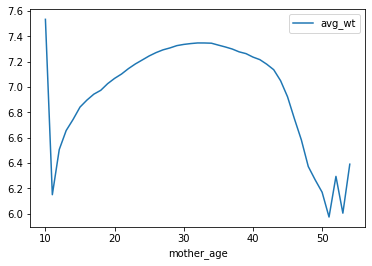

In [ ]:
df.plot(x='mother_age', y='avg_wt');

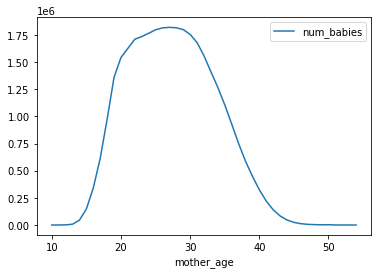

In [ ]:
df.plot(x='mother_age', y='num_babies');

In [ ]:
base_sql = """
CREATE TEMPORARY FUNCTION CLIP_LESS(x FLOAT64, a FLOAT64) AS (
  IF (x < a, a, x)
);
CREATE TEMPORARY FUNCTION CLIP_GT(x FLOAT64, b FLOAT64) AS (
  IF (x > b, b, x)
);
CREATE TEMPORARY FUNCTION CLIP(x FLOAT64, a FLOAT64, b FLOAT64) AS (
  CLIP_GT(CLIP_LESS(x, a), b)
);

WITH stats AS (
    SELECT
      MIN(mother_age) AS min_age,
      MAX(mother_age) AS max_age,
      AVG(mother_age) AS avg_age,
      STDDEV(mother_age) AS stddev_age,
      APPROX_QUANTILES(mother_age, 100)[OFFSET(1)] AS percentile_1,
      APPROX_QUANTILES(mother_age, 100)[OFFSET(99)] AS percentile_99
    FROM
      publicdata.samples.natality
    WHERE
      year > 2000
),

scaling AS (
    SELECT
      mother_age,
      weight_pounds,
      SAFE_DIVIDE(2*mother_age - max_age - min_age, max_age - min_age) AS minmax_scaled,
      CLIP( (mother_age - 30)/15, -1, 1 ) AS clipped,
      SAFE_DIVIDE(mother_age - avg_age, stddev_age) AS zscore,
      CLIP(mother_age, percentile_1, percentile_99) AS winsorized_1_99,
      SAFE_DIVIDE(2*CLIP(mother_age, percentile_1, percentile_99) - percentile_1 - percentile_99, percentile_99 - percentile_1) AS winsorized_scaled
    FROM
      publicdata.samples.natality, stats
)
"""

# DONE bigquery.Client에 프로젝트_이름 전달
def scaled_stats(age_col):
    sql = base_sql + """
SELECT
   {0},
   AVG(weight_pounds) AS avg_wt,
   COUNT(1) AS num_babies
FROM
   scaling
GROUP BY {0}
ORDER BY {0}
    """.format(age_col)
    from google.cloud import bigquery
    return bigquery.Client(project=project_name).query(sql).to_dataframe()

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(3, 2);
scaled_stats('mother_age').plot(x='mother_age', y='num_babies', ax=axs[0, 0]);
scaled_stats('minmax_scaled').plot(x='minmax_scaled', y='num_babies', ax=axs[0, 1]);
scaled_stats('clipped').plot(x='clipped', y='num_babies', ax=axs[1, 0]);
scaled_stats('zscore').plot(x='zscore', y='num_babies', ax=axs[1, 1], xlim=[-2, 2]);
scaled_stats('winsorized_1_99').plot(x='winsorized_1_99', y='num_babies', ax=axs[2, 0]);
scaled_stats('winsorized_scaled').plot(x='winsorized_scaled', y='num_babies', ax=axs[2, 1]);
fig.savefig('scaling.png')
plt.close(fig)

- Skewed data

In [ ]:
%%bigquery df --project project_name
WITH bypage AS (
SELECT 
  title,
  SUM(views) AS num_views
FROM `bigquery-samples.wikipedia_benchmark.Wiki1M`
WHERE language = 'en'
GROUP BY title
HAVING num_views > 10 # non-niche
ORDER by num_views desc
),

percentile AS (
SELECT
  APPROX_QUANTILES(num_views, 100) AS bins
FROM
  bypage
)

SELECT 
  title,
  num_views,
  (ROUND(POW(LOG(num_views), 0.25), 1) - 1.3) AS fourthroot_log_views,
  CAST(REPLACE(ML.BUCKETIZE(num_views, bins), 'bin_', '') AS int64) AS bin,
FROM
  percentile, bypage

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
from scipy import stats
df['num_views'] = df['num_views'].astype(float)
data, est_lambda = stats.boxcox(df['num_views'])
df['boxcox'] = data

In [ ]:
df

,title,num_views,fourthroot_log_views,bin,boxcox
0,Script_kiddie,92485.0,0.5,66,1.836813
1,French/Lessons/Level_two,11.0,-0.1,2,1.340333
2,Italian/Irregular_Verbs,11.0,-0.1,2,1.340333
3,Computer_Programming/Agent_Oriented_Programming,11.0,-0.1,2,1.340333
4,Music_Theory/How_to_read_Music,11.0,-0.1,2,1.340333
...,...,...,...,...,...
39725,Lexi_Belle,2092.0,0.4,65,1.811608
39726,Boeing_767,2398.0,0.4,65,1.813674
39727,Constructivism_(learning_theory),1653.0,0.3,65,1.807664
39728,Strikeforce:_Miami,6988.0,0.4,65,1.825497


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'font.size': 15})
fig, axs = plt.subplots(1, 4);

for axno, name in enumerate('num_views,fourthroot_log_views,bin,boxcox'.split(',')):
   df.hist(histtype='bar', bins=20, column=name, ax=axs[axno]);
fig.savefig('skew_log.png')
plt.close(fig)